In [1]:
from pathlib import Path

import yaml

import math
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, precision_recall_curve, roc_curve

import mlflow
import mlflow.pytorch as ml_pt

from project_modules import (MyResNet34, MyResNet50, TargetTransform, TrainingSupervisor)

In [2]:
data_path = Path("hymenoptera_data")

path_train = data_path/"train"
path_val = data_path/"val"
path_test = data_path/"test"

path_train_mod = data_path/"train_mod"
path_val_mod = data_path/"val_mod"
path_test_mod = data_path/"test_mod"

path_train_bees = path_train/"bees"
path_train_ants = path_train/"ants"
path_val_bees = path_val/"bees"
path_val_ants = path_val/"ants"
path_test_bees = path_test/"bees"
path_test_ants = path_test/"ants"

path_train_bees_mod = path_train_mod/"bees"
path_train_ants_mod = path_train_mod/"ants"
path_val_bees_mod = path_val_mod/"bees"
path_val_ants_mod = path_val_mod/"ants"
path_test_bees_mod = path_test_mod/"bees"
path_test_ants_mod = path_test_mod/"ants"

In [3]:
test_dataset = ImageFolder(root=path_test_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

val_dataset = ImageFolder(root=path_val_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

y_true = np.array(val_dataset.targets).astype(np.float32)

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigmoid_v = np.vectorize(sigmoid)

In [4]:
experiment_name = "Ants Bees Recognition Project"
mlflow.set_experiment(experiment_name)
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
experiment_id

'268962542675260621'

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/maciej/programming/Ants-Bees-Recognition-Project/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

### Loading trained model utilities

In [38]:
def prepare_yaml_file(computer, run_id):
    experiment_path = Path("mlruns")/experiment_id
    meta_yaml_path = experiment_path/run_id/"meta.yaml"
    dell_specific_path = Path("file:///home/macwoj/playground/machine_learning_book/Ants-Bees-Recognition-Project")
    lenovo_specific_path = Path("file:///home/maciej/programming/Ants-Bees-Recognition-Project")

    if computer == "dell":
        with open(meta_yaml_path, 'r') as file:
            data = yaml.safe_load(file)

        artifact_uri_path = str(dell_specific_path/experiment_path/run_id/"artifacts")
        prefix, suffix = artifact_uri_path.split('/', 1)
        data['artifact_uri'] = prefix + "///" + suffix

        with open(meta_yaml_path, 'w') as file:
            yaml.safe_dump(data, file)

    elif computer == "lenovo":
        with open(meta_yaml_path, 'r') as file:
            data = yaml.safe_load(file)

        artifact_uri_path = str(lenovo_specific_path/experiment_path/run_id/"artifacts")
        prefix, suffix = artifact_uri_path.split('/', 1)
        data['artifact_uri'] = prefix + "///" + suffix

        with open(meta_yaml_path, 'w') as file:
            yaml.safe_dump(data, file)

    return artifact_uri_path + "/model_artifacts"

In [39]:
computer = "lenovo"
# run_id_50 = "a8d7bdb46b744532af15bdc55928f4c6"
# run_id_34 = "7a82d7325c37487e80829c6ec9e0ef96"
run_id_50 = "6087d699561f429fa011ee69bc197ae2"
run_id_34 = "0682c9ca1cc34bffa962f9970c773d56"

state_dict_uri = prepare_yaml_file(computer=computer, run_id=run_id_34)

In [40]:
data_dictionary = mlflow.load_table(artifact_file="training_metadata/data_dictionary.json", run_ids=[run_id_34])

In [41]:
data_dictionary.loc[data_dictionary["Validation loss"].idxmin()]

Epoch                  14.000000
Training loss           0.012325
Validation loss         0.018521
Training accuracy      86.764702
Validation accuracy    77.058830
Learning rate           0.010000
Name: 13, dtype: float64

In [42]:
data_dictionary.loc[data_dictionary["Validation accuracy"].idxmax()]

Epoch                   39.000000
Training loss            0.000011
Validation loss          0.053373
Training accuracy      100.000000
Validation accuracy     79.411766
Learning rate            0.002500
Name: 38, dtype: float64

### Evaluate the model

#### ResNet 34

In [43]:
state_dict_uri = prepare_yaml_file(computer=computer, run_id=run_id_34)

if device == "cuda":
    torch.cuda.empty_cache()
model = MyResNet34()

path=Path("./checkpoints/checkpoint.pth")
supervisor = TrainingSupervisor(model=model, early_stop_patience=25, lr=0.01, lr_patience=8, lr_reduce_factor=2, checkpoints_default_filepath=path)
loss_fn = nn.BCEWithLogitsLoss()

mlflow_loaded_state_dict = ml_pt.load_state_dict(state_dict_uri=state_dict_uri, map_location=torch.device(device), weights_only=True)
model.load_state_dict(state_dict=mlflow_loaded_state_dict)

<All keys matched successfully>

In [44]:
_, _, y_scores_pred_tensor = supervisor.check_accuracy(loss_fn=loss_fn, dataloader=val_dataloader, device=device, return_y_scores=True)
y_scores_pred_resnet_34 = y_scores_pred_tensor.to("cpu").numpy().ravel()
y_scores_pred_resnet_34[-10:-1]

array([ 1.1140037 ,  3.8487384 ,  1.631913  ,  0.9197011 ,  3.379211  ,
       -0.63752645,  2.7586462 ,  1.2962008 ,  1.0665026 ], dtype=float32)

In [45]:
y_probas_pred_resnet_34 = sigmoid_v(y_scores_pred_resnet_34)
y_pred_resnet_34 = (y_probas_pred_resnet_34 > 0.5).astype(np.float32)

#### ResNet 50

In [46]:
state_dict_uri = prepare_yaml_file(computer=computer, run_id=run_id_50)

if device == "cuda":
    torch.cuda.empty_cache()
model = MyResNet50()

path=Path("./checkpoints/checkpoint.pth")
supervisor = TrainingSupervisor(model=model, early_stop_patience=25, lr=0.01, lr_patience=8, lr_reduce_factor=2, checkpoints_default_filepath=path)
loss_fn = nn.BCEWithLogitsLoss()

mlflow_loaded_state_dict = ml_pt.load_state_dict(state_dict_uri=state_dict_uri, map_location=torch.device(device), weights_only=False)
model.load_state_dict(state_dict=mlflow_loaded_state_dict)

<All keys matched successfully>

In [47]:
_, _, y_scores_pred_tensor = supervisor.check_accuracy(loss_fn=loss_fn, dataloader=val_dataloader, device=device, return_y_scores=True)
y_scores_pred_resnet_50 = y_scores_pred_tensor.to("cpu").numpy().ravel()
y_scores_pred_resnet_50[:10]

array([-1.3413593 , -1.7197503 , -1.5461733 , -1.7411435 ,  0.82398534,
       -1.7495059 , -1.5118215 ,  1.7454108 ,  0.05304095, -2.0943642 ],
      dtype=float32)

In [48]:
y_probas_pred_resnet_50 = sigmoid_v(y_scores_pred_resnet_50)
y_pred_resnet_50 = (y_probas_pred_resnet_50 > 0.5).astype(np.float32)

### Show evaluation

In [49]:
print("ResNet 34 accuracy:")
print(accuracy_score(y_true, y_pred_resnet_34), "\n")
print("ResNet 50 accuracy:")
print(accuracy_score(y_true, y_pred_resnet_50))

ResNet 34 accuracy:
0.7529411764705882 

ResNet 50 accuracy:
0.7411764705882353


In [50]:
print("ResNet 34 f1_score:")
print(f1_score(y_true, y_pred_resnet_34), "\n")
print("ResNet 50 f1_score:")
print(f1_score(y_true, y_pred_resnet_50))

ResNet 34 f1_score:
0.7529411764705882 

ResNet 50 f1_score:
0.7441860465116279


In [51]:
print("ResNet 34 roc_auc_score:")
print(roc_auc_score(y_true, y_scores_pred_resnet_34), "\n")
print("ResNet 50 roc_auc_score:")
print(roc_auc_score(y_true, y_scores_pred_resnet_50))

ResNet 34 roc_auc_score:
0.8452595155709342 

ResNet 50 roc_auc_score:
0.8346020761245675


In [52]:
print("ResNet 34 confusion matrix:")
print(confusion_matrix(y_true, y_pred_resnet_34), "\n")
print("ResNet 50 confusion matrix:")
print(confusion_matrix(y_true, y_pred_resnet_50))

ResNet 34 confusion matrix:
[[64 21]
 [21 64]] 

ResNet 50 confusion matrix:
[[62 23]
 [21 64]]


In [53]:
prob_and_label = np.array(list(zip(y_scores_pred_resnet_50, y_true)))
np.argmax(prob_and_label, axis=0)

array([116,  85])

In [54]:
prob_and_label[63]

array([3.1172624, 0.       ], dtype=float32)

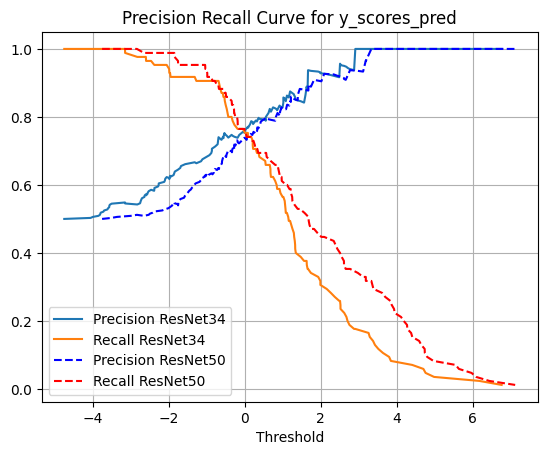

In [55]:
def plot_precision_recall_vs_threshold(precisions_34, recalls_34, thresholds_34, precisions_50, recalls_50, thresholds_50):
    plt.plot(thresholds_34, precisions_34[:-1], "")
    plt.plot(thresholds_34, recalls_34[:-1], "")
    plt.plot(thresholds_50, precisions_50[:-1], "b--")
    plt.plot(thresholds_50, recalls_50[:-1], "r--")
    plt.legend(["Precision ResNet34", "Recall ResNet34", "Precision ResNet50", "Recall ResNet50"])
    plt.xlabel("Threshold")
    plt.grid()

precisions_34, recalls_34, thresholds_34 = precision_recall_curve(y_true, y_scores_pred_resnet_34)
precisions_50, recalls_50, thresholds_50 = precision_recall_curve(y_true, y_scores_pred_resnet_50)
plot_precision_recall_vs_threshold(precisions_34, recalls_34, thresholds_34, precisions_50, recalls_50, thresholds_50)
plt.title("Precision Recall Curve for y_scores_pred")
plt.show()

# precisions_34, recalls_34, thresholds_34 = precision_recall_curve(y_true=y_true, y_score=y_probas_pred_resnet_34)
# precisions_50, recalls_50, thresholds_50 = precision_recall_curve(y_true=y_true, y_score=y_probas_pred_resnet_50)
# plot_precision_recall_vs_threshold(precisions_34, recalls_34, thresholds_34, precisions_50, recalls_50, thresholds_50)
# plt.title("Precision Recall Curve for y_probas_pred")
# plt.show()

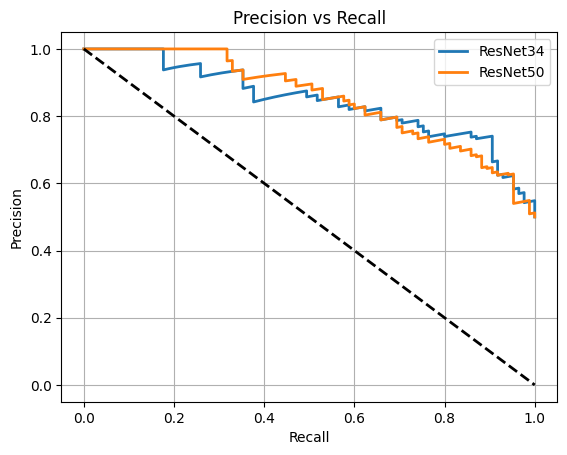

In [56]:
plt.plot(recalls_34, precisions_34, linewidth=2)
plt.plot(recalls_50, precisions_50, linewidth=2)
plt.plot([0, 1], [1, 0], "k--", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.legend(["ResNet34", "ResNet50"])
plt.grid()
plt.show()

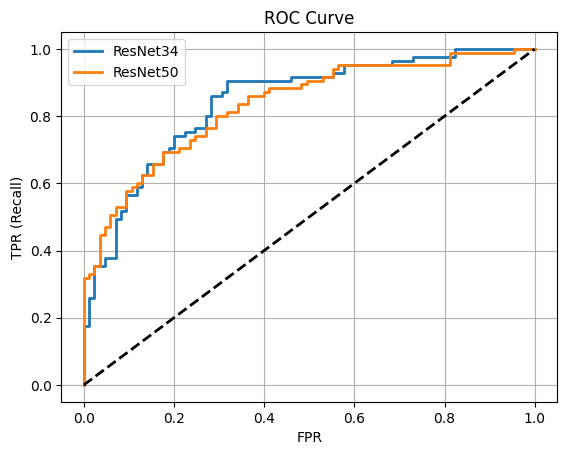

In [57]:
fpr_34, tpr_34, _ = roc_curve(y_true=y_true, y_score=y_scores_pred_resnet_34)
fpr_50, tpr_50, _ = roc_curve(y_true=y_true, y_score=y_scores_pred_resnet_50)
def plot_roc_curve(fpr_34, tpr_34, fpr_50, tpr_50, label=None):
    plt.plot(fpr_34, tpr_34, linewidth=2, label=label)
    plt.plot(fpr_50, tpr_50, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2) # dashed diagonal
    plt.grid()
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.legend(["ResNet34", "ResNet50"])
    plt.title("ROC Curve")
plot_roc_curve(fpr_34, tpr_34, fpr_50, tpr_50)
plt.show()